<a href="https://colab.research.google.com/github/joey0320/reversemethod/blob/colabcodes/RM_USING_EXCEL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!git clone https://github.com/joey0320/reversemethod.git

Cloning into 'reversemethod'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 62 (delta 15), reused 44 (delta 7), pack-reused 0
Unpacking objects: 100% (62/62), done.


In [0]:
#!git clone https://github.com/joey0320/reversemethod.git

Cloning into 'reversemethod'...
remote: Enumerating objects: 62, done.
remote: Counting objects: 100% (62/62), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 62 (delta 15), reused 44 (delta 7), pack-reused 0
Unpacking objects: 100% (62/62), done.


In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun Apr 12 07:24:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
import matplotlib.pyplot as plt
import math
import os
from tqdm import tqdm
import time
import cv2
#from DataCaller_Excel import DataCaller_Excel
#from Model import Net
#from EarlyStop import EarlyStopping

#use gpu    please somebody buy me a gpu .......
USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

#Global variables
LOAD_DATA = True
BATCH_SIZE = 32
VAL_BATCH_SIZE = 32
LEARNING_RATE = 1e-3
EPOCHS = 1000
PATIENCE = 25
VALIDATE_EVERY = 10
MODEL_NAME = f"model-{int(time.time())}"
IMG_SIZE = 64
IMG_CHANNELS = 1
OUTPUT_LABEL_SIZE = 8

cuda


In [0]:

class DataCaller_Excel(Dataset):
    def __init__(self, data_path, inputsize):
        
        self.data_path = data_path
        self.inputsize = inputsize
        
        data = pd.read_excel(open(self.data_path, 'rb'), sheet_name='Sheet1', header=None)
        data = np.array(data)
        data = data.reshape(-1, 1, inputsize, inputsize)
        self.data = torch.from_numpy(data).float()
        
        label = pd.read_excel(open(self.data_path, 'rb'), sheet_name='Sheet2', header=None)
        self.label = torch.from_numpy( np.array(label) ).float()
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        x = torch.FloatTensor(self.data[idx])
        y = torch.FloatTensor(self.label[idx])
        return x, y

In [0]:

class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [0]:
import torch
import torch.nn as nn

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv2d(IMG_CHANNELS, 12, kernel_size=3, padding=1),
            nn.ReLU(),
            #nn.BatchNorm2d(8),
            #nn.Conv2d(12, 12, kernel_size=3, padding=1),
            #nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #32 x 32 x 12
            
            nn.Conv2d(12, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            #nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #16 x 16 x 16
            
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #8 x 8 x 32

            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #4 x 4 x 32
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            #nn.Conv2d(64, 64, kernel_size=3, padding=1),
            #nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #2 x 2 x 64

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            #1 x 1 x 128
            
        )
        self.fcc = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.4),
            #nn.Linear(256, 48),
            #nn.ReLU(),
            #nn.Dropout(0.4),
            nn.Linear(64, OUTPUT_LABEL_SIZE)
        )
    def forward(self, x):
        output = self.cnn(x)
        output = output.view(output.size(0), -1)
        output = self.fcc(output)
        return output

In [0]:
#data path
DRIVE_PATH = '/content/gdrive/My Drive/Colab Notebooks'
BASE_PATH = '2source'
TRAIN_PATH_LABEL = os.path.join(DRIVE_PATH, 'data', BASE_PATH, 'train')
VAL_PATH_LABEL = os.path.join(DRIVE_PATH, 'data', BASE_PATH, 'val')
TEST_PATH_LABEL = os.path.join(DRIVE_PATH, 'data', BASE_PATH, 'test')
LOAD_PRETRAINED_PATH = 'checkpoint.pt'
#TRAIN_PATH_IMG = os.path.join(DRIVE_PATH, 'images', BASE_PATH, 'train')
#VAL_PATH_IMG = os.path.join(DRIVE_PATH, 'images', BASE_PATH, 'val')
#TEST_PATH_IMG = os.path.join(DRIVE_PATH, 'images', BASE_PATH, 'test')

In [6]:
if LOAD_DATA:
    trainsets = []
    valsets = []
    testsets = []
    for f in tqdm(os.listdir(TRAIN_PATH_LABEL)):
      path = os.path.join(TRAIN_PATH_LABEL, f)
      trainset = DataCaller_Excel(path, IMG_SIZE)
      print(trainset.__len__())
      trainsets.append(trainset)

    for f in tqdm(os.listdir(VAL_PATH_LABEL)):
      path  = os.path.join(VAL_PATH_LABEL, f)
      valset = DataCaller_Excel(path, IMG_SIZE)
      print(valset.__len__())
      valsets.append(valset)

    for f in tqdm(os.listdir(TEST_PATH_LABEL)):
      path  = os.path.join(TEST_PATH_LABEL, f)
      testset = DataCaller_Excel(path, IMG_SIZE)
      print(testset.__len__())
      testsets.append(testset)

    trainset = ConcatDataset(trainsets)
    print(trainset.__len__())
    valset = ConcatDataset(valsets)
    print(valset.__len__())
    testset = ConcatDataset(testsets)
    print(testset.__len__())
    #trainset = DataCaller(TRAIN_PATH_IMG, TRAIN_PATH_LABEL, IMG_SIZE)
    #valset = DataCaller(VAL_PATH_IMG, VAL_PATH_LABEL, IMG_SIZE)
    #testset = DataCaller(TEST_PATH_IMG, TEST_PATH_LABEL, IMG_SIZE)

  4%|▍         | 1/25 [01:11<28:37, 71.57s/it]

1000


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-da75bb6333f7>", line 7, in <module>
    trainset = DataCaller_Excel(path, IMG_SIZE)
  File "<ipython-input-2-766b2eec6a11>", line 13, in __init__
    label = pd.read_excel(open(self.data_path, 'rb'), sheet_name='Sheet2', header=None)
  File "/usr/local/lib/python3.6/dist-packages/pandas/io/excel/_base.py", line 304, in read_excel
    io = ExcelFile(io, engine=engine)
  File "/usr/local/lib/python3.6/dist-packages/pandas/io/excel/_base.py", line 824, in __init__
    self._reader = self._engines[engine](self._io)
  File "/usr/local/lib/python3.6/dist-packages/pandas/io/excel/_xlrd.py", line 21, in __init__
    super().__init__(filepath_or_buffer)
  File "/usr/local/lib/python3.6/dist-packages/pandas/io/excel/_base.py", line 351, in __init__
    self.book = self.load_workbo

KeyboardInterrupt: ignored

In [0]:
#define dataloaders
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE, shuffle=True)
valloader = DataLoader(valset, batch_size=VAL_BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=1, shuffle=False)

In [87]:
#just checking if the data is loaded properly
cnt = 0
for i, data in enumerate(trainloader):
    x, y = data
    
    #print(x)
    x = np.array(x)
    x = x.reshape(-1, IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
    #print(x)
    x = x.astype(int)
    print(x[0].shape)
    #plt.imshow(x[0].reshape(IMG_SIZE, IMG_SIZE, -1))
    #plt.imshow(x[0].reshape(IMG_SIZE, IMG_SIZE, -1), cmap='gray')
    #plt.show()
    #print(x[0])
    print(y)
    cnt += 1
    if cnt==10:
      break

(1, 64, 64)
tensor([[2.6405e+01, 1.4300e+01, 1.7218e+01, 1.4256e+01, 1.7333e+00, 1.0833e+01,
         8.2840e+00, 8.0062e+00],
        [2.8819e+01, 1.4757e+00, 2.3145e+01, 1.8003e-01, 4.3007e+00, 2.1390e+01,
         1.8155e-01, 5.4597e+00],
        [7.8338e+00, 2.5895e+01, 5.4494e-01, 1.5020e+00, 2.9360e+00, 4.9543e+00,
         3.2345e+00, 3.5045e+00],
        [1.9692e+01, 1.8843e+01, 1.7310e+01, 1.4148e+01, 8.2338e+00, 4.9775e+00,
         4.1554e+00, 2.0953e+00],
        [1.8675e+01, 2.5699e+00, 1.5317e+01, 1.1414e+00, 9.3263e+00, 1.5135e+01,
         1.6494e+00, 9.4035e+00],
        [1.2709e+01, 2.2889e+01, 4.3184e+00, 7.8724e+00, 6.5092e+00, 1.1954e+01,
         4.0549e+00, 2.0580e+00],
        [2.2160e+01, 1.9324e+01, 9.2688e+00, 1.1373e+01, 1.1698e+00, 1.4085e+01,
         1.7946e+01, 5.0333e+00],
        [7.5274e+00, 2.4054e+01, 7.1473e-01, 2.3250e+01, 2.4439e+00, 5.8595e+00,
         1.3141e+01, 9.9791e+00],
        [1.5205e+01, 1.8159e+01, 6.8916e+00, 6.1053e+00, 2.0684e+00,

In [0]:
def weighted_mse(input, target, weight):
  input = input.to(device)
  target = target.to(device)
  weight = weight.to(device)
  return torch.sum(weight * (input - target)**2)

In [0]:
#train the model
def train(net, model_name, patience, validate_every):
    
    optimizer = optim.Adam(net.parameters(), LEARNING_RATE, betas=(0.9, 0.999), eps=1e-09, weight_decay=0, amsgrad=False)
    weight = torch.tensor([1, 1, 3, 3, 15, 3, 3, 15])
    
    #train_errors = []
    #val_errors = []

    train_losses = []
    val_losses = []
    avg_train_losses = []
    avg_val_losses = []
    early_stopping = EarlyStopping(patience=patience, verbose=True)

    with open("model.log", "a") as f:
        for epoch in tqdm(range(EPOCHS)):
                net.train()
                for batch_idx, samples in enumerate(trainloader):
                    x, y = samples
                    x = x.view(-1, IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
                    
                    x = x.to(device)
                    y = y.to(device)
                    
                    pred = net(x)
                    loss = weighted_mse(pred, y, weight)
                    net.zero_grad()
                    loss.backward()
                    optimizer.step()
                    
                    #error = (pred - y) / y
                    #error = error.mean(0)
                    train_losses.append(loss.item())
                    #train_errors.append(error.to("cpu"))
                    #if idx%validate_every == 0:
                net.eval()
                for batch_idx, samples in enumerate(valloader):
                    val_x, val_y = samples
                    
                    val_x = val_x.to(device)
                    val_y = val_y.to(device)
                    
                    val_x = val_x.view(-1, IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
                    val_pred = net(val_x)
                    val_loss = weighted_mse(val_pred, val_y, weight)
                    #val_error = (val_pred - val_y) / val_y
                    #val_error = val_error.mean(0)
                    val_losses.append(val_loss.item())
                    #val_errors.append(val_error.to("cpu"))

                train_loss = np.average(train_losses)
                valid_loss = np.average(val_losses)
                avg_train_losses.append(train_loss)
                avg_val_losses.append(valid_loss)
                
                #train_error = np.average(train_errors)
                #val_error= np.average(val_errors)

                train_losses = []
                val_losses = []
                #train_errors = []
                #val_errors = []

                f.write(f"{MODEL_NAME},{round(time.time(), 3)},  {round(float(train_loss), 4)},  {round(float(valid_loss),4)}\n")
                #print("batch : ", batch_idx)
                print("\nloss : ", train_loss, "val loss : ", valid_loss, "\n")
                #print("error : ", train_error, "val error : ", val_error)
                
                early_stopping(valid_loss, net)
                
                if early_stopping.early_stop:
                    print("Early stopping")
                    break
        # load the last checkpoint with the best model
        net.load_state_dict(torch.load('checkpoint.pt'))
        
        return avg_train_losses, avg_val_losses

In [94]:
net = Net()
print(net)


Net(
  (cnn): Sequential(
    (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): Dropout(p=0.4, inplace=False)
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(32, 64, kernel_size=(3, 3), st

In [0]:
net.to(device)
train_loss, valid_loss = train(net, MODEL_NAME, PATIENCE, VALIDATE_EVERY)









  0%|          | 0/1000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)








  0%|          | 1/1000 [00:08<2:13:24,  8.01s/it]


loss :  nan val loss :  nan 

Validation loss decreased (inf --> nan).  Saving model ...










  0%|          | 2/1000 [00:15<2:13:07,  8.00s/it]


loss :  nan val loss :  nan 

Validation loss decreased (nan --> nan).  Saving model ...










  0%|          | 3/1000 [00:24<2:13:00,  8.00s/it]


loss :  nan val loss :  nan 

Validation loss decreased (nan --> nan).  Saving model ...










  0%|          | 4/1000 [00:31<2:12:27,  7.98s/it]


loss :  nan val loss :  nan 

Validation loss decreased (nan --> nan).  Saving model ...


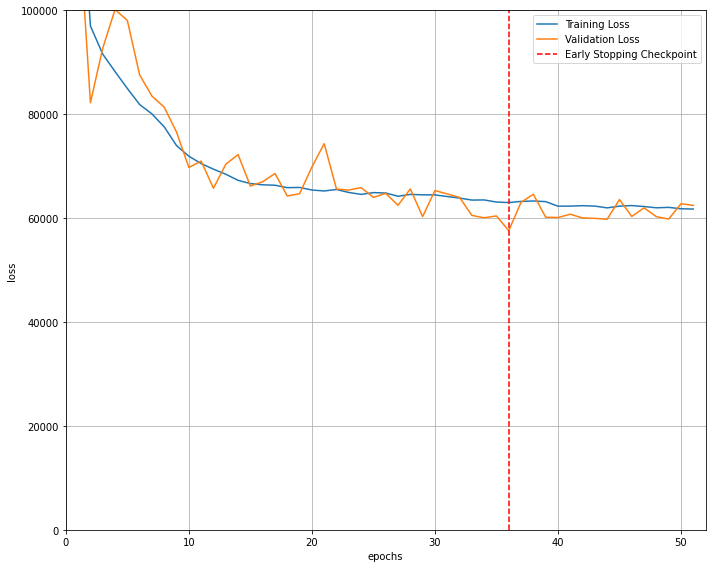

In [42]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 100000) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

In [0]:
def test(net):
    predictions = []
    with torch.no_grad():
        for i, sample in enumerate(testloader):
            x ,y = sample
            x = x.view(-1, IMG_CHANNELS, IMG_SIZE, IMG_SIZE)
            
            x = x.to(device)
            y = y.to(device)
            
            predict = net(x)
            predict = predict.to("cpu")
            predict = np.array(predict)
            predictions.append(predict)
            

    print(predictions)
    print()
    predictions = np.array(predictions)
    predictions = predictions.reshape(-1, OUTPUT_LABEL_SIZE)
    df = DataFrame(predictions)
    df.to_excel('predictions.xlsx', header=None)

In [44]:
trained_net = Net()
trained_net.load_state_dict(torch.load(LOAD_PRETRAINED_PATH))
trained_net.to(device)
trained_net.eval()
test(trained_net)

[array([[18.353104, 18.457363,  9.463928,  9.637369, 10.999495, 10.325655,
        10.235207, 10.682175]], dtype=float32), array([[18.361881 , 13.209066 ,  9.692144 ,  5.337966 , 11.57901  ,
        10.771109 ,  6.008119 , 11.2637825]], dtype=float32), array([[18.138384, 17.329334,  9.930953,  7.991269, 10.123297, 10.707336,
         8.47896 ,  9.88181 ]], dtype=float32), array([[16.40769  , 26.368313 ,  9.204128 , 16.183037 ,  9.8548355,
         9.716637 , 16.41596  ,  9.601453 ]], dtype=float32), array([[18.033394 ,  9.529263 ,  9.220274 ,  3.0503497,  9.568365 ,
        10.092901 ,  3.6188395,  9.394237 ]], dtype=float32), array([[16.794773, 23.154285,  8.025744, 15.100733, 11.934507,  8.837437,
        15.709272, 11.519289]], dtype=float32), array([[14.330297 , 23.993216 ,  6.8331327, 15.786728 , 10.076918 ,
         7.335462 , 16.085693 ,  9.776856 ]], dtype=float32), array([[14.846701, 29.200928,  6.68731 , 21.053436, 11.157587,  7.21474 ,
        21.422503, 10.743513]], dtype=f